# **Validation Suite**

## Purpose and Setup
This notebook will allow you to test the output from WRF-GHG against surface, upper air, and satelite observations.

The next cell imports modules needed to work properly

In [1]:
import wrf
import numpy as np
import pandas as pd
from datetime import datetime as dt
from netCDF4 import Dataset #type: ignore
from termcolor import cprint
from numpy import unravel_index
import collections.abc as c
import metpy as mp

### *Base class*

This class is used for all the following classes in order to give some basic location data to each class.

In [2]:
class Base_point:
    '''
    Base_point: parent class for validation. Sets location name.
    '''
    def __init__(self: object, loc: str, **kwargs) -> None:
        self.loc = loc

### *Upper air (UA) class*

This class is used to set the attributes for any data objects that cares about upper air data. This is usually the WRF data that you're testing or the radiosonde data you use for validation. It inherits from the base class.

In [3]:
class UA_point(Base_point):
    def __init__(self: object, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def __eq__(self: object, other: object) -> bool:
        try:
            results: np.ndarray[bool] = np.empty(5, bool)
            results[0] = np.allclose(self.p, other.p, atol=10.)
            results[1] = np.allclose(self.t, other.t, atol=1.)
            results[2] = np.allclose(self.td, other.td, atol=1.)
            results[3] = np.allclose(self.wdir, other.wdir, atol=5.)
            results[4] = np.allclose(self.wspd, other.wspd, atol=1.)
            result: bool = results.all()
        except AttributeError:
            if isinstance(self, WRF_point):
                result: bool = other.__eq__(self)
            else:
                raise NotImplementedError('Compairison not implemented')
        finally:
            return result

### *Satelite (Sat) class*

This class is used to set the attributes for any data objects that cares about satelite data. This is usually the WRF data or TROPOMI or OCO-2 data. It inherits from the base class. **Note**: The respective classes for TROPOMI and OCO-2 are still in development (9-9-2024)

In [4]:
class Sat_point(Base_point):
    def __init__(self: object, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def sat_loc(self: object, ulat: float, ulon: float, lats: c.Iterable[float], lons: c.Iterable[float]) -> tuple[int, int] | int:
        R = 6371000
        lat1 = np.radians(ulat)
        lat2 = np.radians(lats)
        delta_lat = np.radians(lats-ulat)
        delta_lon = np.radians(lons-ulon)
        a = (np.sin(delta_lat/2))*(np.sin(delta_lat/2))+(np.cos(lat1))*(np.cos(lat2))*(np.sin(delta_lon/2))*(np.sin(delta_lon/2))
        c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d = R*c
        if d.ndim == 1:
            return d.argmin()
        else:
            x, y = unravel_index(d.argmin(),d.shape)
            return x,y
    def __eq__(self: object, other: object) -> bool:
        result: bool | None = None
        try:
            if isinstance(self, Tropomi_point) or (isinstance(self, WRF_point) and isinstance(other, Tropomi_point)):
                results: np.ndarray[bool] = np.empty(2, bool)
                results[0] = np.abs(self.xch4 - other.xch4) <= 1.e-1
                results[1] = np.abs(self.xco - other.xco) <= 1.e-1
                result = results.all()
            #! elif for OCO-2 here
        except AttributeError:
            if isinstance(self, WRF_point):
                result = other.__eq__(self)
            else:
                result = NotImplemented
        else:
            if result is None:
                if isinstance(self,WRF_point):
                    result = other.__eq__(self)
                else:
                    raise NotImplementedError('Compairison not implemented')
            else:
                pass
        finally:
            return result

### *Surface class*

This class is used to set the attirbutes for any data object that cares about surface data. This is usually the WRF data or the ASOS observation data. It inherits from the base class.

In [5]:
class Surface_point(Base_point):
    def __init__(self: object, loc: str, **kwargs) -> None:
        super().__init__(loc, **kwargs)
    def __eq__(self: object, other: object) -> bool:
        try:
            results: np.ndarray[bool] = np.empty(5, bool)
            results[0] = abs(self.T2 - other.T2) <= 0.5
            results[1] = abs(self.td2 - other.td2) <= 0.5
            results[2] = abs(self.slp - other.p) <= 3.0
            results[3] = abs(self.wspd10 - other.wspd10) <= 0.2
            results[4] = abs(self.wdir10 - other.wdir10) <= 5
            result: bool = results.all()
        except AttributeError:
            if isinstance(self, WRF_point):
                result: bool = other.__eq__(self)
            else:
                raise NotImplementedError('Comparison not implemented')
        finally:
            return result

### *WRF class*

This class ingests the wrfout data that you need to run the validation suite. Since it's what we're testing, it inherits from UA, Sat, and Surface classes.

In [51]:
class WRF_point(Surface_point,Sat_point,UA_point):
    '''
    WRF_point: sets up validation point using WRF data. Reads T2, TD2, SLP, and 10m Wind speed/direction. Inherits from Base_point.
    '''
    def __init__(self: object, wrffile: Dataset, lat: float, lon: float, loc: str, chem: bool | None = None, **kwargs) -> None:
        super().__init__(loc,**kwargs)
        self.lat: float = lat
        self.lon: float = lon
        self.x, self.y = wrf.ll_to_xy(wrffile,self.lat,self.lon)
        self.vars = ['T2', 'td2', 'slp','uvmet10_wspd_wdir','p','temp','td','uvmet_wspd_wdir']
        for var in self.vars:
            if var == 'T2':
                self.T2 = wrf.getvar(wrffile, var)[self.y, self.x].metpy.quantify()
            elif var == 'td2':
                self.td2 = wrf.getvar(wrffile, var, units='K')[self.y, self.x].metpy.quantify()
            elif var == 'slp':
                self.slp = wrf.getvar(wrffile, var, units='hPa')[self.y, self.x].metpy.quantify()
            elif var == 'uvmet10_wspd_wdir':
                self.wspd10, self.wdir10 = wrf.getvar(wrffile, var)[:, self.y, self.x].metpy.quantify()
            elif var == 'p':
                self.p = wrf.getvar(wrffile, var, units='hPa')[:, self.y, self.x].metpy.quantify()
            elif var == 'temp':
                self.t = wrf.getvar(wrffile, var)[:, self.y, self.x].metpy.quantify()
            elif var == 'td':
                self.td = wrf.getvar(wrffile, var, units='K')[:, self.y, self.x].metpy.quantify()
            elif var == 'uvmet_wspd_wdir':
                self.wspd, self.wdir = wrf.getvar(wrffile, var)[..., self.y, self.x] 
        ## ! Next if/elif block needs to be edited depending on WRF-GHG output structure (include converting units) ! ## 
        self.sfc_pres = wrf.getvar(wrffile, 'PSFC')[self.y, self.x] #! may need to calculate or may be in WRF output
        if chem is True:
            self.xch4 = self._extract_ghg(wrffile, 'xch4')
            self.xco = self._extract_ghg(wrffile, 'xco')
            self.xco2 = self._extract_ghg(wrffile, 'xco2')
    def _extract_ghg(self, wrffile: Dataset, chem: str):
        if chem == 'xch4':
            _ant = wrffile['CH4_ANT'][0, :, self.y, self.x]
            _bck = wrffile['CH4_BCK'][0, :, self.y, self.x]
            _tst = wrffile['CH4_TST'][0, :, self.y, self.x]
        elif chem == 'xco2':
            _ant = wrffile['CO2_ANT'][0, :, self.y, self.x]
            _bck = wrffile['CO2_BCK'][0, :, self.y, self.x]
            _tst = wrffile['CO2_TST'][0, :, self.y, self.x]
        elif chem == 'xco':
            _ant = wrffile['CO_ANT'][0, :, self.y, self.x]
            _bck = wrffile['CO_BCK'][0, :, self.y, self.x]
            #_tst = wrffile['CO_BIO'][0, :, self.y, self.x] ##?
            _tst = np.zeros_like(_bck)
        _ghg = _tst + _ant -_bck
        if len(_ghg) == len(self.p):
            pres_bound = np.empty_like(self.p)
            for i, pres in enumerate(self.p):
                if i == 0:
                    pres_bound[i] = self.sfc_pres
                    pres_bound[i+1] = pres_bound[i] + (2*(pres-pres_bound[i]))
                else:
                    try:
                        pres_bound[i+1] = pres_bound[i] + (2*(pres-pres_bound[i]))
                    except IndexError:
                        pass
        p_layer_diff = np.array([pres_bound[i]-pres_bound[i-1] for i in range(1,len(pres_bound))]) #! This may need a value at beginning for xch4[0]
        p_diff = pres_bound[0] - pres_bound[-1]
        return np.sum(_ghg*p_layer_diff)/p_diff
    def __str__(self) -> str:
        return f'{self.loc} WRF Point has a temperature of {self.T2} K, a dewpoint of {self.td2} K, a slp of {self.slp} hPa, and the wind is {self.wspd10} m s^-1 at {self.wdir10} degrees.'

## *UObs_point Class*

This class ingest sounding data to test against WRF data. This inherits from UA point.

In [7]:
class UObs_point(UA_point):
    def __init__(self, loc, ua_file, wrffile, lat, lon, **kwargs):
        super().__init__(loc, **kwargs)
        x, y = wrf.ll_to_xy(wrffile, lat, lon)
        wrf_p = wrf.getvar(wrffile, 'p', meta=False, units='hPa')[:, y, x]
        data = pd.read_csv(ua_file, na_values='M', parse_dates=['validUTC'], date_format='%Y-%m-%d %H:%M')
        p = data.pressure_mb.to_numpy()
        idx = np.digitize(wrf_p, p)
        data = data.iloc[idx]
        self.p = data.pressure_mb.to_numpy() #* mb == hPa
        self.t = data.tmpc.to_numpy() + 273.15 #* deg C -> K
        self.td = data.dwpc.to_numpy() + 273.15 #* deg C -> K
        self.wdir = data.drct.to_numpy() #* deg
        self.wspd = data.speed_kts.to_numpy() * 0.514444 #* kt -> m s^-1
        del data, p, idx, wrf_p, x, y

In [52]:
lat = 40.87
lon = -72.87

wrf_file = '../wrfout_d02_2023-07-21_00:00:00'
wrf_ds = Dataset(wrf_file)
loc = 'Brookhaven (KOKX)'
ua_file = '../KOKX_2023072100_2023072112.txt'
wrf_data = WRF_point(wrf_ds, lat, lon, loc)
ua_data = UObs_point(loc, ua_file, wrf_ds, lat, lon)

In [10]:
ua_data == wrf_data

False

In [15]:
np.allclose(ua_data.t, wrf_data.t, atol=25.)

False

In [17]:
print(f'{len(ua_data.t) = }, {len(wrf_data.t) = }')

len(ua_data.t) = 47, len(wrf_data.t) = 47


In [19]:
print(f'{ua_data.t[20] = }, {wrf_data.t[20] = }')

ua_data.t[20] = nan, wrf_data.t[20] = 284.64853


In [74]:
from metpy.units import units
import matplotlib.pyplot as plt
from datetime import datetime as dt
import metpy.calc as mpcalc
from metpy.plots import SkewT
def skewt_plot(data_point, data_type, date_tuple):
    golden = (1. + np.sqrt(5.))/2.
    figsize = (12./golden, 12.)
    fig = plt.figure(figsize=figsize)
    #wspd = data_point.wspd.metpy.convert_units('knots')
    #wspd = wspd.metpy.dequantify()
    #wdir = data_point.wdir.metpy.dequantify()
    skew = SkewT(fig, rotation=45)
    skew.plot(data_point.p, data_point.t.metpy.convert_units('degC'), 'r')
    skew.plot(data_point.p, data_point.td.metpy.convert_units('degC'), 'g')
    u, v = mpcalc.wind_components(data_point.wspd, data_point.wdir)
    skew.plot_barbs(data_point.p, u, v)
    skew.ax.set_ylim(1000,100)
    skew.ax.set_xlim(-40,60)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.set_title(f'{data_type} Skew T, {dt(*date_tuple).strftime("%Y-%m-%d %H")}z')
    plt.savefig(f'{data_type}_{dt(*date_tuple).strftime("%Y-%m-%d_%H")}z.png')
    plt.show()
    plt.close()

DimensionalityError: Cannot convert from 'meter / second' ([length] / [time]) to 'radian' (dimensionless)

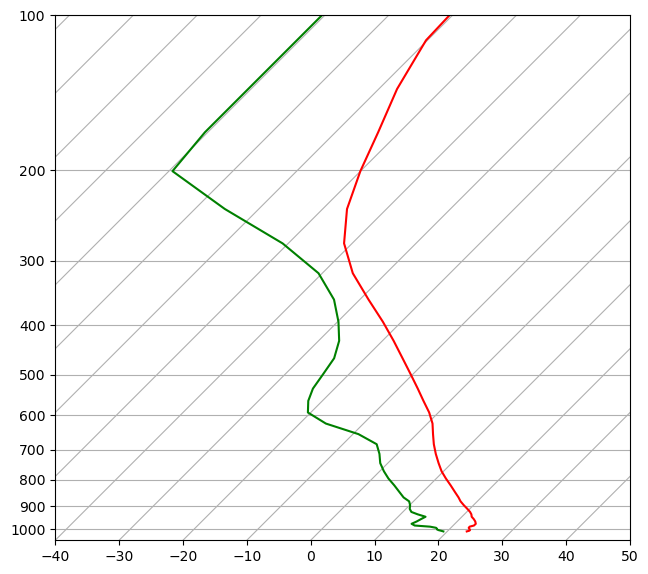

In [77]:
skewt_plot(wrf_data, 'Modeled', (2023,7,21,0,0))

In [73]:
wrf_data.wdir.metpy.dequantify()

<xarray.DataArray 'uvmet_wspd_wdir' (bottom_top: 47)> Size: 188B
array([211.66339 , 203.69458 , 198.17213 , 192.84262 , 186.84758 ,
       179.38016 , 170.05614 , 163.85645 , 153.10065 , 139.04597 ,
       121.94021 ,  95.663956,  61.59958 ,  25.835327, 352.43878 ,
       342.82596 , 344.87912 , 345.09567 , 333.29373 , 313.7196  ,
       309.8659  , 314.89618 , 315.6775  , 311.60135 , 307.19376 ,
       300.80807 , 290.16736 , 277.5312  , 268.8721  , 264.9713  ,
       263.38043 , 263.3202  , 261.88617 , 257.77936 , 253.03453 ,
       250.80217 , 251.75745 , 254.1155  , 257.17245 , 261.1651  ,
       264.172   , 262.9715  , 254.43398 , 176.91742 , 104.37501 ,
       107.82464 ,  95.0345  ], dtype=float32)
Coordinates:
    wspd_wdir     <U4 16B 'wdir'
    XLONG         float32 4B -72.87
    XLAT          float32 4B 40.87
    XTIME         float32 4B 1.44e+03
    Time          datetime64[ns] 8B 2023-07-21
    latlon_coord  object 8B CoordPair(lat=40.87, lon=-72.87)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  earth rotated wspd,wdir
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.000003814...
    units:        meter / second

In [45]:
ua_data.t

array([ 23. ,  23. ,  23. ,  23. ,  23. ,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   9.6,   7.8,   nan,   3.2,   1.2,   nan,
         nan,   nan, -10.3,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan, -49.3,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, -44.3])

In [79]:
wrf_ds['U']

<class 'netCDF4._netCDF4.Variable'>
float32 U(Time, bottom_top, south_north, west_east_stag)
    FieldType: 104
    MemoryOrder: XYZ
    description: x-wind component
    units: m s-1
    stagger: X
    coordinates: XLONG_U XLAT_U XTIME
unlimited dimensions: Time
current shape = (1, 47, 285, 331)
filling on, default _FillValue of 9.969209968386869e+36 used